### Інсталювання бібліотек та імпорти

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
!pip install pyarrow --quiet

In [3]:
import os
import joblib
import warnings
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, f1_score

### Вступ

В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

## Task 0
Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/edce80b5bb02479085855b2334b17fc1). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

In [4]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2/data'

In [5]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dariiaskalat
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 1.06MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu-course-c-2/bank-customer-churn-prediction-dlu-course-c-2.zip to ./bank-customer-churn-prediction-dlu-course-c-2




---



## Task 1

Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [6]:
data_dir = './bank-customer-churn-prediction-dlu-course-c-2'

In [7]:
os.listdir(data_dir)

['train.csv', 'sample_submission.csv', 'test.csv']

In [8]:
train_csv = data_dir + '/train.csv'

In [9]:
raw_train_csv = pd.read_csv(train_csv)

In [10]:
raw_train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


**Навчальна вибірка**

  *використовується для навчання моделі, тобто для обчислення втрат і налаштування ваг моделі за допомогою оптимізаційної техніки.*

**Валідаційна вибірка**

  *використовується для оцінки моделі під час навчання, налаштування гіперпараметрів моделі (оптимізаційна техніка, регуляризація тощо) та вибору найкращої версії моделі. Вибір хорошої валідаційної вибірки є важливим для навчання моделей, які добре узагальнюють.*

> **Якщо окрема тестова вибірка вже надана, ви можете використовувати розподіл 75%-25% для навчання та валідації.**

**Параметр stratify у train_test_split**

  *stratify дозволяє зберегти пропорцію класів у навчальному та тестовому наборах такою ж, як у вихідному наборі даних. Це особливо корисно, коли дані мають незбалансовані класи.*

  *Якщо передати stratify=y, де y — це цільова змінна (мітки класів), то метод train_test_split поділить дані таким чином, щоб у навчальному та тестовому наборах відсоткове співвідношення класів залишилося таким самим, як у всьому датасеті.*

In [11]:
train_set, val_set = train_test_split(
    raw_train_csv,
    test_size=0.25,  # 25% валідаційний набір адже в нас вже є тестовий окремий набір даних
    stratify=raw_train_csv['Exited'],  # це наш таргет з мітками
    random_state=42
)

In [12]:
print('train_set.shape :', train_set.shape)
print('val_set.shape :', val_set.shape)

train_set.shape : (11250, 14)
val_set.shape : (3750, 14)




---



## Task 2
* Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`.
* Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [13]:
input_cols = list(train_set.columns)[1:-1]
target_col = 'Exited'

In [14]:
print('Input Columns: ', input_cols)
print('Target Column: ', target_col)

Input Columns:  ['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Target Column:  Exited


In [15]:
# Customer ID: Унікальний ідентифікатор для кожного клієнта (це поле містить дублікати для різної інформації клієнтів, тому його не варто використовувати для input_cols)
# Surname: Не думаю, що прізвище клієнта має хоч якийсь вплив на цільову змінну, тому його не варто використовувати для input_cols
# Оновлю значення input_cols
input_cols = input_cols[2:]

print('Input Columns: ', input_cols)
print('Target Column: ', target_col)

Input Columns:  ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Target Column:  Exited


In [16]:
train_inputs = train_set[input_cols].copy()
train_targets = train_set[target_col].copy()

val_inputs = val_set[input_cols].copy()
val_targets = val_set[target_col].copy()



---



## Task 3
Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [17]:
numeric_cols = raw_train_csv[input_cols].select_dtypes(include=np.number).columns.tolist()
categorical_cols = raw_train_csv[input_cols].select_dtypes(include='object').columns.tolist()

In [18]:
print('Numeric Columns:\n', numeric_cols)
print()
print('Categorical Columns:\n', categorical_cols)

Numeric Columns:
 ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

Categorical Columns:
 ['Geography', 'Gender']




---



## Task 4

* Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти передобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак,
  - вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

    Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
    1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
    2) має бути виконана принаймні одна дія передобробки
    3) обробка має бути виконана коректно і для тренувальних, і для валідаційних даних
    4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

    Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите?
  
* По завершенню виведіть по 5 значень з `train_inputs`, `val_inputs` використовуючи `display()`.

In [19]:
# Перевірю чи взагалі є пропущені значення у всьому датасеті
raw_train_csv.isna().sum()

,0
id,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


Пропущених значень немає взагалі і це чудово. Нічого робити не потрібно.

In [20]:
# Спочатку попрацюємо з категорільними колонками
train_inputs[categorical_cols].nunique()

,0
Geography,3
Gender,2


**Спостереження**
* Оскільки локацій де проживає клієнт (Geography) є всього 3 (Франція, Іспанія або Німеччина), я вважаю, що цю колонку варто закодувати, і отримати числові колонки, які можна використати в моделюванні. І звичайне map використовувати не можна, адже логістична регресія трактує числові значення як порядкові і може сприймати Geography = 3 (Germany) як "більш важливе" або "вище" значення, ніж Geography = 1 (France), що спотворить навчання моделі. Тому я скористаюся one-hot encoding.
* Гендерів (Gender) також лише 2 і їх можна також перевести в числовий формат. Думаю використати LabelEncoder. Або я використаю для простоти теж OneHotEncoder але з опцією drop='first', що буде корисно і для локації і для гендера - уникнемо мультиколінеарності.

In [21]:
encoder = OneHotEncoder(drop='first', sparse_output=False)

In [22]:
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(drop='first', sparse_output=False)

In [23]:
encoder.categories_

[array(['France', 'Germany', 'Spain'], dtype=object),
 array(['Female', 'Male'], dtype=object)]

In [24]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Geography_Germany', 'Geography_Spain', 'Gender_Male']


In [25]:
drop_after_encoding = list(encoder.feature_names_in_)

In [26]:
drop_after_encoding

['Geography', 'Gender']

In [27]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [28]:
# Видалю з inputs вже непотрібні категоріальні колонки Geography, Gender
train_inputs.drop(columns=drop_after_encoding, inplace=True)
val_inputs.drop(columns=drop_after_encoding, inplace=True)

In [29]:
display(train_inputs.head(5))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8263,696.0,32.0,5.0,130627.66,1.0,1.0,1.0,86786.41,0.0,0.0,1.0
14199,632.0,32.0,4.0,119825.75,1.0,1.0,0.0,177737.04,1.0,0.0,0.0
1856,679.0,22.0,4.0,0.00,2.0,1.0,1.0,162599.54,0.0,0.0,0.0
3013,705.0,48.0,3.0,0.00,2.0,1.0,0.0,119814.25,0.0,0.0,1.0
8266,696.0,35.0,7.0,0.00,2.0,1.0,0.0,100423.88,0.0,0.0,0.0


In [30]:
display(val_inputs.head(5))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
1855,543.0,29.0,9.0,119688.81,1.0,0.0,0.0,55815.62,0.0,0.0,1.0
1273,598.0,41.0,3.0,123863.64,1.0,1.0,0.0,176868.89,1.0,0.0,1.0
5414,621.0,31.0,7.0,0.00,1.0,1.0,1.0,150242.44,0.0,0.0,1.0
10923,597.0,56.0,3.0,0.00,4.0,1.0,0.0,102936.71,0.0,0.0,1.0
5835,749.0,42.0,5.0,0.00,1.0,1.0,1.0,181794.86,0.0,1.0,0.0


In [31]:
# Поглянемо тепер на числові колонки
raw_train_csv[numeric_cols].describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00
mean,658.94,37.74,5.03,42729.79,1.59,0.79,0.49,117784.67
std,72.26,8.22,2.78,59727.31,0.53,0.41,0.50,45734.45
min,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83058.14
50%,662.00,37.00,5.00,0.00,2.00,1.00,0.00,123584.87
75%,708.00,42.00,7.00,109531.02,2.00,1.00,1.00,156884.70
max,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48


Числові ознаки мають значення в різних масштабах, а тому їх варто масштабувати, я використаю MinMaxScaler.
Також мене турбує колонка Balance адже там дуже великий розрив - пустий баланс мають 50% - це досить багато.

In [32]:
# Проведу аналіз впливу колонок ознак на таргет - створю heatmap
# Використаю тільки числові колонки для кореляційної матриці
corr_matrix = raw_train_csv[numeric_cols + [target_col]].corr()
corr_matrix
# Виведу список кореляцій для всіх колонок з Target
print(corr_matrix[target_col].sort_values(ascending=False))

Exited             1.000000
Age                0.464689
Balance            0.153025
EstimatedSalary    0.023796
Tenure            -0.011637
HasCrCard         -0.017616
CreditScore       -0.047703
IsActiveMember    -0.193615
NumOfProducts     -0.288563
Name: Exited, dtype: float64


Можливо, треба буде спробувати потім видалити якісь не дуже кореляційні ознаки. Але це вже пізніше.

In [33]:
# Опрацюю колонку Balance перед масштабуванням, бо така як є вона думаю сильно впливатиме на результат
# Функція для створення нових ознак: HasBalance - чи є взагалі баланс, Balance_log - прологарифмований баланс (бо коли є баланс то він здоровечий)
def balance_transform(df):
    df = df.copy()  # Щоб не змінювати вихідний DataFrame
    df['HasBalance'] = (df['Balance'] > 0).astype(int)
    df['Balance_log'] = np.log1p(df['Balance'])
    df.drop(columns=['Balance'], inplace=True)  # Видаляю непотрібний Balance
    return df

# Обгортаємо функцію у FunctionTransformer
balance_encoder = FunctionTransformer(balance_transform, validate=False)

In [34]:
train_inputs = balance_encoder.transform(train_inputs)
val_inputs = balance_encoder.transform(val_inputs)

In [35]:
train_inputs[['HasBalance', 'Balance_log']].describe().round(2)

,HasBalance,Balance_log
count,11250.00,11250.00
mean,0.35,4.11
std,0.48,5.58
min,0.00,0.00
25%,0.00,0.00
50%,0.00,0.00
75%,1.00,11.61
max,1.00,12.25


In [36]:
train_inputs.columns

Index(['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male', 'HasBalance', 'Balance_log'],
      dtype='object')

In [37]:
val_inputs.columns

Index(['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male', 'HasBalance', 'Balance_log'],
      dtype='object')

In [38]:
# тепер можна масштабувати дані
scaler = MinMaxScaler(feature_range=(0.0, 1.0))

In [39]:
scaler.fit(train_inputs)

MinMaxScaler(feature_range=(0.0, 1.0))

In [40]:
train_inputs = pd.DataFrame(scaler.transform(train_inputs), columns=train_inputs.columns)
val_inputs = pd.DataFrame(scaler.transform(val_inputs), columns=val_inputs.columns)

In [41]:
train_inputs.describe().round(2)

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,HasBalance,Balance_log
count,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00
mean,0.54,0.36,0.50,0.20,0.79,0.49,0.59,0.18,0.22,0.57,0.35,0.34
std,0.17,0.15,0.28,0.18,0.41,0.50,0.23,0.38,0.41,0.49,0.48,0.46
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.41,0.26,0.30,0.00,1.00,0.00,0.42,0.00,0.00,0.00,0.00,0.00
50%,0.55,0.35,0.50,0.33,1.00,0.00,0.62,0.00,0.00,1.00,0.00,0.00
75%,0.66,0.44,0.70,0.33,1.00,1.00,0.78,0.00,0.00,1.00,1.00,0.95
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [42]:
val_inputs.describe().round(2)

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,HasBalance,Balance_log
count,3750.00,3750.00,3750.00,3750.00,3750.00,3750.00,3750.00,3750.00,3750.00,3750.00,3750.00,3750.00
mean,0.54,0.37,0.50,0.20,0.78,0.49,0.59,0.17,0.22,0.55,0.35,0.33
std,0.17,0.16,0.28,0.18,0.41,0.50,0.23,0.38,0.41,0.50,0.48,0.45
min,0.01,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.41,0.26,0.30,0.00,1.00,0.00,0.41,0.00,0.00,0.00,0.00,0.00
50%,0.55,0.35,0.50,0.33,1.00,0.00,0.62,0.00,0.00,1.00,0.00,0.00
75%,0.66,0.44,0.70,0.33,1.00,1.00,0.79,0.00,0.00,1.00,1.00,0.95
max,1.00,1.04,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.99


In [43]:
display(train_inputs.head(5))

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,HasBalance,Balance_log
0,0.632458,0.259259,0.5,0.000000,1.0,1.0,0.433916,0.0,0.0,1.0,1.0,0.961347
1,0.479714,0.259259,0.4,0.000000,1.0,0.0,0.888712,1.0,0.0,0.0,1.0,0.954303
2,0.591885,0.074074,0.4,0.333333,1.0,1.0,0.813017,0.0,0.0,0.0,0.0,0.000000
3,0.653938,0.555556,0.3,0.333333,1.0,0.0,0.599071,0.0,0.0,1.0,0.0,0.000000
4,0.632458,0.314815,0.7,0.333333,1.0,0.0,0.502109,0.0,0.0,0.0,0.0,0.000000


In [44]:
display(val_inputs.head(5))

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,HasBalance,Balance_log
0,0.267303,0.203704,0.9,0.0,0.0,0.0,0.279047,0.0,0.0,1.0,1.0,0.954210
1,0.398568,0.425926,0.3,0.0,1.0,0.0,0.884371,1.0,0.0,1.0,1.0,0.957008
2,0.453461,0.240741,0.7,0.0,1.0,1.0,0.751226,0.0,0.0,1.0,0.0,0.000000
3,0.396181,0.703704,0.3,1.0,1.0,0.0,0.514675,0.0,0.0,1.0,0.0,0.000000
4,0.758950,0.444444,0.5,0.0,1.0,1.0,0.909003,0.0,1.0,0.0,0.0,0.000000




---



## Task 5
* Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`.
* В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [45]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (11250, 12)
train_targets: (11250,)
val_inputs: (3750, 12)
val_targets: (3750,)


In [46]:
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')

In [47]:
%%time
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')

CPU times: user 9.93 ms, sys: 872 µs, total: 10.8 ms
Wall time: 10.9 ms


In [48]:
os.listdir('./')

['.config',
 'bank-customer-churn-prediction-dlu-course-c-2',
 'val_inputs.parquet',
 'train_targets.parquet',
 'val_targets.parquet',
 'train_inputs.parquet',
 'sample_data']



---



## Task 6
* З підготовлених вхідних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі.
* Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [49]:
X_train = pd.read_parquet('train_inputs.parquet')
y_train = pd.read_parquet('train_targets.parquet')

X_val = pd.read_parquet('val_inputs.parquet')
y_val = pd.read_parquet('val_targets.parquet')

In [50]:
model = LogisticRegression(solver='lbfgs')

In [51]:
model.fit(X_train, y_train.values.ravel())

LogisticRegression()

In [52]:
coefs = model.coef_.round(2)
for col in X_train.columns:
    print(f'{col}: {coefs[0][X_train.columns.get_loc(col)]}')

CreditScore: -0.83
Age: 8.19
Tenure: -0.09
NumOfProducts: -3.96
HasCrCard: -0.18
IsActiveMember: -1.24
EstimatedSalary: 0.19
Geography_Germany: 1.65
Geography_Spain: -0.08
Gender_Male: -0.88
HasBalance: -0.38
Balance_log: -0.36


Можливо видалю потім Tenure i Geography_Spain з інпутів. Якщо точність можелі буде погана.



---



## Task 7
Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [53]:
def determine_quality(model, X, target, threshold=0.5):
    # Отримуємо ймовірності
    target_predicted_proba = model.predict_proba(X)[:, 1]

    # Перетворюємо ймовірності у бінарні передбачення за допомогою порогу
    target_predicted = (target_predicted_proba >= threshold).astype(int)

    # Обчислюємо accuracy
    accuracy = accuracy_score(target, target_predicted)
    print(f'Accuracy: {accuracy}\n')

    # Обчислюємо F1 score
    f1 = f1_score(target, target_predicted)
    print(f'F1 Score: {f1}\n')

    # Створюємо confusion matrix
    confusion = confusion_matrix(target, target_predicted)
    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Обчислюємо ROC AUC
    fpr, tpr, thresholds = roc_curve(target, target_predicted_proba)
    roc_auc = auc(fpr, tpr)
    print(f'ROC AUC: {roc_auc}')

    # Показуємо ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

Accuracy: 0.8741333333333333

F1 Score: 0.6369230769230769



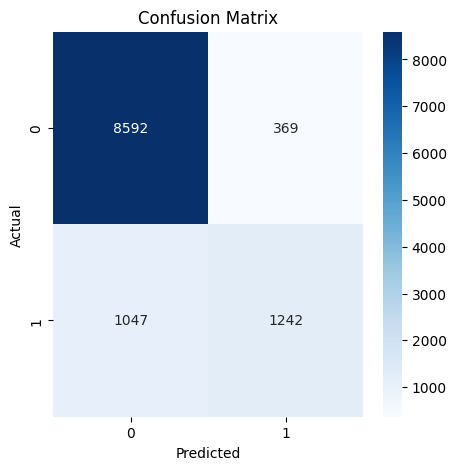

ROC AUC: 0.8828259675232644


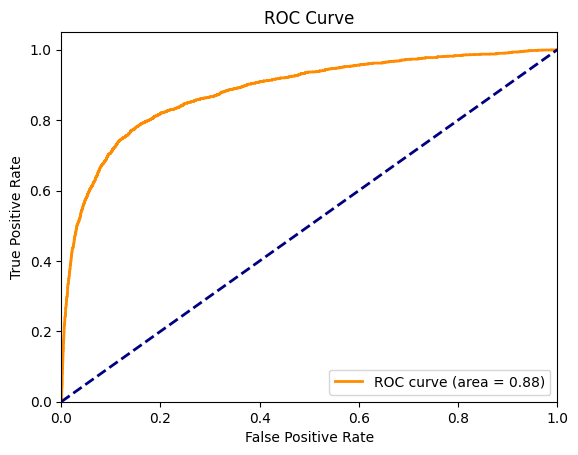

In [54]:
determine_quality(model, X_train, y_train)

* 0.64 F1 score - це такий собі результат. Модель має помірну здатність правильно класифікувати позитивні та негативні випадки. Є куди краще.

* AUROC - 0.88 свідчить про те що модель досить добре розрізняє позитивні і негативні класи.

* Крива ROC знаходиться над діагоналлю, що свідчить про певну prediction power. Оскільки вона досить далеко від діагоналі і притиснута більш менш до ліній - то сила передбачення досить неопгана.

* Можна побачити, що помилково негативних випадків (1047) більше, ніж помилково позитивних (369). Модель трохи погано виявляє позитивний клас (який нас дуже цікавить). Думаю можна спробувати змінити поріг.

Accuracy: 0.8704888888888889

F1 Score: 0.6637433648742211



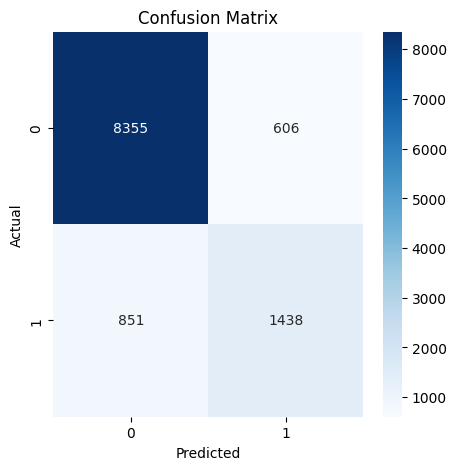

ROC AUC: 0.8828259675232644


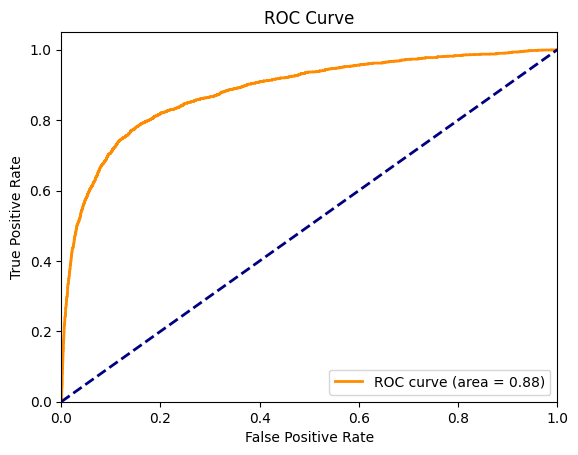

In [55]:
determine_quality(model, X_train, y_train, 0.4)

In [56]:
# Перевірю дисбаланс класів
print("Розподіл класів у TRAIN:")
print(y_train.value_counts(normalize=True))

print("\nРозподіл класів у VAL:")
print(y_val.value_counts(normalize=True))

Розподіл класів у TRAIN:
Exited
0.0       0.796533
1.0       0.203467
Name: proportion, dtype: float64

Розподіл класів у VAL:
Exited
0.0       0.796533
1.0       0.203467
Name: proportion, dtype: float64


Видно, що тих хто покидає банк значно менше ~20% ніж тих хто лишається в банку ~80%. Можливо, саме тому в мене такий поганий False Negative показник.

Accuracy: 0.8722666666666666

F1 Score: 0.6384905660377358



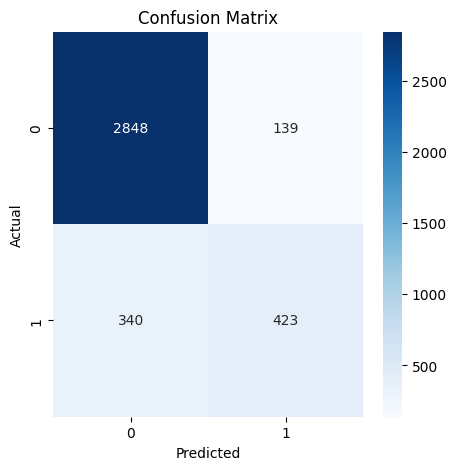

ROC AUC: 0.8800771012526539


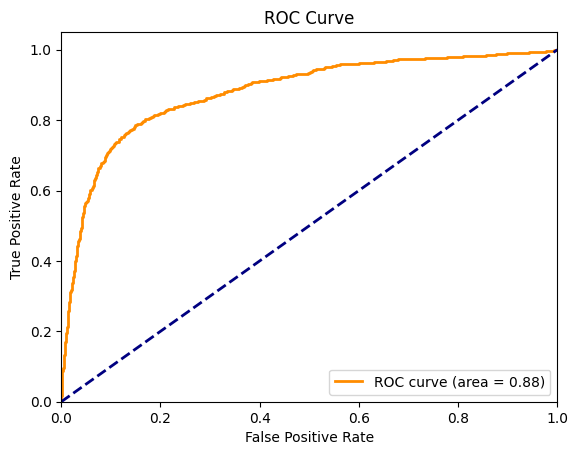

In [57]:
determine_quality(model, X_val, y_val, 0.5)

Accuracy: 0.872

F1 Score: 0.6774193548387096



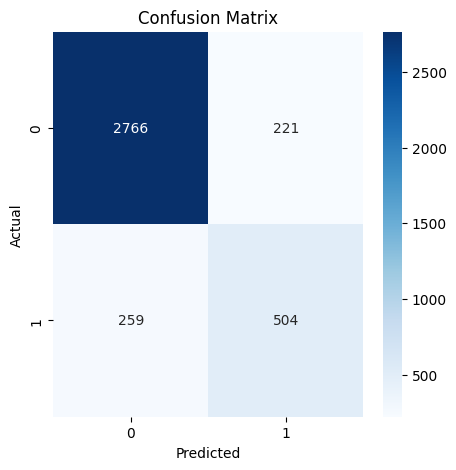

ROC AUC: 0.8800771012526539


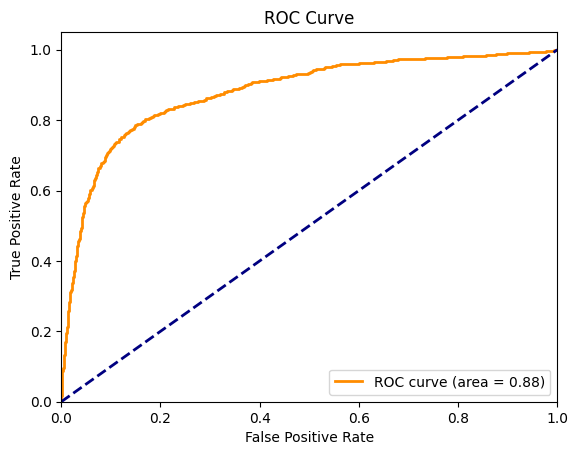

In [58]:
determine_quality(model, X_val, y_val, 0.4)



---



## Task 8
* Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних).
* Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в Task 6.
* Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [59]:
majority_class = y_train.value_counts().idxmax()
print(f"Мажоритарний клас: {majority_class}")

Мажоритарний клас: (0.0,)


In [60]:
y_train_dummy = np.full_like(train_targets, fill_value=majority_class)
y_val_dummy = np.full_like(val_targets, fill_value=majority_class)

In [61]:
accuracy_train_dummy = accuracy_score(train_targets, y_train_dummy)
accuracy_val_dummy = accuracy_score(val_targets, y_val_dummy)

print(f"Accuracy Dummy Model (Train): {accuracy_train_dummy:.2f}")
print(f"Accuracy Dummy Model (Val): {accuracy_val_dummy:.2f}")

Accuracy Dummy Model (Train): 0.80
Accuracy Dummy Model (Val): 0.80


Точність на "дурній" моделі - 80% Фінальна точність моделі - 87% Все ж, моя модель трішечки краща.

In [62]:
np.random.seed(42)
y_train_random = np.random.randint(0, 2, size=len(train_targets))
y_val_random = np.random.randint(0, 2, size=len(val_targets))

accuracy_train_random = accuracy_score(train_targets, y_train_random)
accuracy_val_random = accuracy_score(val_targets, y_val_random)

print(f"Accuracy Random Model (Train): {accuracy_train_random:.2f}")
print(f"Accuracy Random Model (Val): {accuracy_val_random:.2f}")

Accuracy Random Model (Train): 0.50
Accuracy Random Model (Val): 0.50


Точність на "випадковій" моделі - 50% Фінальна точність моделі - 87%. Тут моя модель значно краща.

Я хочу спробувати видалити Tenure та Geography_Spain і подивитися, якими будуть результати моєї моделі без них.

In [63]:
cols_to_drop_try = ['Tenure', 'Geography_Spain']
X_train_try = X_train.drop(columns=cols_to_drop_try)
X_val_try = X_val.drop(columns=cols_to_drop_try)

In [64]:
model_try = LogisticRegression(solver='lbfgs', class_weight='balanced')
model_try.fit(X_train_try, y_train.values.ravel())

LogisticRegression(class_weight='balanced')

Accuracy: 0.8237333333333333

F1 Score: 0.6492128073589245



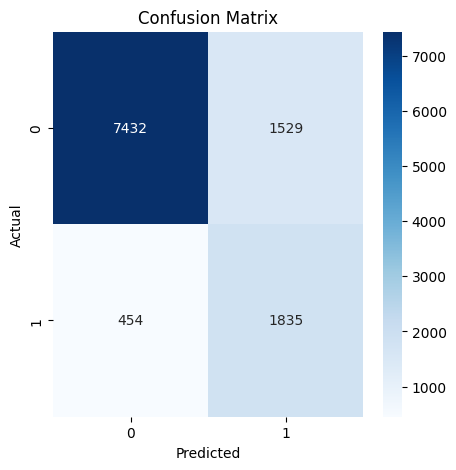

ROC AUC: 0.8842073722795383


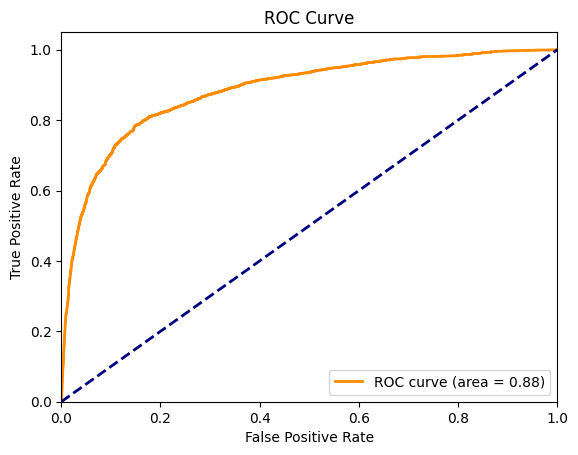

In [65]:
determine_quality(model_try, X_train_try, y_train)

Accuracy: 0.8109333333333333

F1 Score: 0.6351003602676274



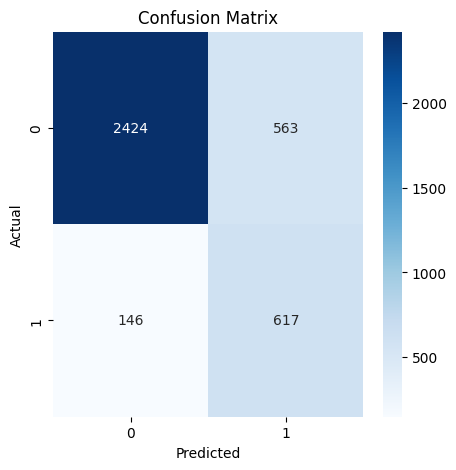

ROC AUC: 0.8803061409401421


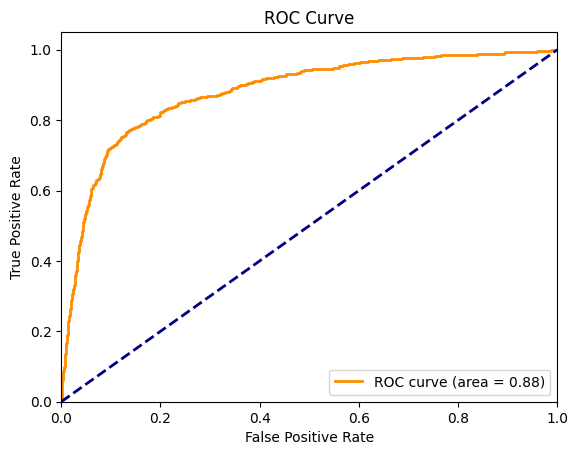

In [66]:
determine_quality(model_try, X_val_try, y_val)

Порівняю:

**Final TRAIN**
* Accuracy: 0.8722666666666666
* F1 Score: 0.6384905660377358
* ROC AUC: 0.8800771012526539

**Try TRAIN**
* Accuracy: 0.8237333333333333
* F1 Score: 0.6492128073589245
* ROC AUC: 0.8842073722795383

*Accuracy дещо знизилася. Однак F1 Score та ROC AUC дещо збільшилися.*

**Final VAL**
* Accuracy: 0.872
* F1 Score: 0.6774193548387096
* ROC AUC: 0.8800771012526539

**Try VAL**
* Accuracy: 0.8109333333333333
* F1 Score: 0.6351003602676274
* ROC AUC: 0.8803061409401421

*Думаю що краще залишити мою фінальну версію моделі без видалених Tenure, Geography_Spain.*

**ВИСНОВОК**

Враховуючи те, що моя модель має хороший показник AUROC (який особливо важливий для логістичної регресії) і я досить знизила False Negative думаю, що якість моєї моделі задовільна. Але звісно, можна й краще.



---



## Task 9
* Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`.
* Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [67]:
bank = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'balance_func': balance_transform,
    'balance_encoder': balance_encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols,
    'determine_quality_func': determine_quality
}

In [68]:
joblib.dump(bank, 'log_reg.joblib')

['log_reg.joblib']

In [69]:
model_2 = joblib.load('log_reg.joblib')['model']

In [70]:
model_2

LogisticRegression()

In [71]:
bank_data = joblib.load('log_reg.joblib')



---



## Task 10
* Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

* Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [74]:
print(f"Model: {model}")
print(f"Scaler: {scaler}")
print(f"Encoder: {encoder}")
print(f"Balance Encoder: {balance_encoder}")
print(f"Numeric Columns: {numeric_cols}")
print(f"Categorical Columns: {categorical_cols}")
print(f"Encoded Columns: {encoded_cols}")

Model: LogisticRegression()
Scaler: MinMaxScaler(feature_range=(0.0, 1.0))
Encoder: OneHotEncoder(drop='first', sparse_output=False)
Balance Encoder: FunctionTransformer(func=<function balance_transform at 0x78119edffb00>)
Numeric Columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Categorical Columns: ['Geography', 'Gender']
Encoded Columns: ['Geography_Germany', 'Geography_Spain', 'Gender_Male']


In [79]:
raw_train_csv.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [80]:
train_inputs.columns

Index(['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male', 'HasBalance', 'Balance_log'],
      dtype='object')

In [108]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(model, scaler, encoder, balance_encoder, numeric_cols, categorical_cols, encoded_cols, input_df: pd.DataFrame):
    # Create a copy of the input DataFrame to avoid modifying the original
    input_df = input_df.copy()

    # Create list of input columns
    if 'Exited' in input_df.columns:
        input_cols = list(input_df.columns)[1:-1]
    else:
        input_cols = list(input_df.columns)[1:]

    # Create inputs
    inputs = input_df[input_cols]

    # Drop not needed Surname and CustomerId columns from inputs
    inputs.drop(columns=['Surname', 'CustomerId'], inplace=True)

    # Encode categorical columns of input_df
    inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])

    # Remove not needed columns after encoding
    drop_after_encoding = list(encoder.feature_names_in_)
    inputs.drop(columns=drop_after_encoding, inplace=True)

    # transform Balance column
    inputs = balance_encoder.transform(inputs)

    # Check if all columns are numerical
    if inputs.select_dtypes(include=np.number).columns.tolist() != list(inputs.columns):
        not_num_cols = [col for col in inputs.columns if not pd.api.types.is_numeric_dtype(inputs[col])]
        raise ValueError(f"Not all columns are numerical after transformation:\n{not_num_cols}")

    # Scale all columns
    scaled_inputs = pd.DataFrame(scaler.transform(inputs), columns=inputs.columns, index=inputs.index)

    # Predict probabilities with custom threshold
    prob = model.predict_proba(scaled_inputs)[:,1]
    threshold = 0.4
    # We have float type in example 'sample_submission'
    #prob = (prob >= threshold).astype(float)

    return prob

In [93]:
predict_raw_df(model, scaler, encoder, balance_encoder, numeric_cols, categorical_cols, encoded_cols, raw_train_csv[20:45])

array([0.07363864, 0.04217169, 0.06821873, 0.04167098, 0.05792244,
       0.0085356 , 0.34054538, 0.06544088, 0.04310411, 0.02133088,
       0.01261187, 0.59553355, 0.03935864, 0.28286221, 0.08040793,
       0.01196792, 0.22639253, 0.03136179, 0.01841307, 0.02909253,
       0.00916124, 0.01805377, 0.02235315, 0.02942281, 0.0388309 ])

Мені не дуже зрозуміло що саме має повертати ця функція - ймовірності чи конкретні передбачення. Тому зараз я додам поріг свій і зроблю щоб функція повертала конкретні передбачення.


In [95]:
predict_raw_df(model, scaler, encoder, balance_encoder, numeric_cols, categorical_cols, encoded_cols, raw_train_csv[70:95])

array([0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0.])



---



## Task 11
* Зчитайте дані з `test.csv` в змінну `test_raw_df`.
* Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [87]:
test_csv = data_dir + '/test.csv'

In [88]:
test_raw_df = pd.read_csv(test_csv)

In [96]:
test_raw_df['Exited'] = predict_raw_df(model, scaler, encoder, balance_encoder, numeric_cols, categorical_cols, encoded_cols, test_raw_df)

In [97]:
test_raw_df.head(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.0
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.0
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.0
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.0
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.0




---



## Task 12
* Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
* Виведіть перші 5 рядків фінального датасету.
* Збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!)
* Здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [102]:
sample_csv = data_dir + '/sample_submission.csv'

In [103]:
my_sample = pd.read_csv(sample_csv)

In [104]:
my_sample.head(5)

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [105]:
my_sample['Exited'] = test_raw_df['Exited']

In [106]:
my_sample.head(5)

,id,Exited
0,15000,0.0
1,15001,0.0
2,15002,0.0
3,15003,0.0
4,15004,0.0


In [107]:
my_sample.to_csv('submission_log_reg.csv', index=False)

Здала я сабмішен і прочитала що все таки треба ймовірності. Йой!

In [111]:
test_raw_df_final = pd.read_csv(test_csv)

In [112]:
test_raw_df_final['Exited'] = predict_raw_df(model, scaler, encoder, balance_encoder, numeric_cols, categorical_cols, encoded_cols, test_raw_df_final)

In [113]:
test_raw_df_final.head(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.083971
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.035260
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.153402
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.201349
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.056389


In [114]:
my_sample_final = pd.read_csv(sample_csv)

In [115]:
my_sample_final.head()

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [116]:
my_sample_final['Exited'] = test_raw_df_final['Exited']

In [117]:
my_sample_final.head()

,id,Exited
0,15000,0.083971
1,15001,0.035260
2,15002,0.153402
3,15003,0.201349
4,15004,0.056389


In [118]:
my_sample_final.to_csv('submission_log_reg_final.csv', index=False)